---
<center>
    <font size='7'>
        <b>Segmentez des clients d'un site e-commerce</b>
    </font>
</center>
 <center>
    <font size='7'>
        <br>Partie 1    
    </font>  
</center>

---

<font size='5'>
<b>Client</b> : Olist<br>
<b>Objectif</b> : Fournir une segmentation de clients aux équipes d'e-commerces pour une utilisation quotidienne lors de leurs campagnes de communication.
</font>

# <font size='7'>1) Exploration</font>
Dans cette première partie, nous explorerons et nettoierons les données. Il faudra identifier les informations pertinentes présentes dans les différents datasets fournis, combiner les datasets et exploiter les données pour la segmentation de clients.

In [1]:
# Inline function to format code to PEP8.
%load_ext lab_black

In [2]:
# Importing necessary librairies.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import datetime

# Machine Learning libraries.
from sklearn.preprocessing import (
    OneHotEncoder,
    LabelBinarizer,
    LabelEncoder,
    StandardScaler,
    scale,
)
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import silhouette_score

In [3]:
# Display options for pandas.
pd.set_option("display.max_row", 100)
pd.set_option("display.max_columns", 40)

# Path to save images.
path = "Images/Part01/"

# Les datasets sont importés

In [4]:
# Importing the csv files provided.
df_customers = pd.read_csv("olist_customers_dataset.csv")
df_geolocation = pd.read_csv("olist_geolocation_dataset.csv")
df_order_items = pd.read_csv("olist_order_items_dataset.csv")
df_order_payments = pd.read_csv("olist_order_payments_dataset.csv")
df_order_reviews = pd.read_csv("olist_order_reviews_dataset.csv")
df_orders = pd.read_csv("olist_orders_dataset.csv")
df_products = pd.read_csv("olist_products_dataset.csv")
df_sellers = pd.read_csv("olist_sellers_dataset.csv")

# This dataframe will be used to translate the PRODUCTS that are in brazilian portuguese.
df_product_category_name_translation = pd.read_csv(
    "product_category_name_translation.csv"
)

# Fonctions pour comparer et combiner les datasets.

In [5]:
# Function aiming at comparing the columns of two dataframes.
def CompareColumns(data1, data2):
    """
    This function search for columns present in columns_1 and in columns_2.
    [Arguments]
    - data1 : first dataframe whose columns will be compared to the second one.
    - data2 : second dataframe whose columns will be compared to the first one.
    """
    # Variables to store column names.
    columns_1 = data1.columns
    columns_2 = data2.columns
    # List to store column names.
    List_1 = []
    for col in columns_1:
        if col in columns_2:
            List_1.append(col)
    for col in columns_2:
        if col in columns_1:
            List_1.append(col)
    common_columns = list(set(List_1))

    return common_columns

In [6]:
# Function to combine more than two dataframes.
def Combine_dataframes(df, frame_list):
    """
    This function merges dataframes from frame_list on df using
    common features among them.
    The merged dataframe is returned.
    [Arguments]:
        - df : dataframe on which the other dataframes will be merged.
        - frame_list : list of dataframes to be merged to df_init.
    """
    # Merging the dataframes by completing information on customers.
    for dataframe in frame_list:
        common_columns = CompareColumns(df, dataframe)
        if len(common_columns) != 0:
            df = pd.merge(df, dataframe, how="outer", on=common_columns)
    return df

# Combinaison de quelques datasets
A partir d'ici, la ligne conductrice est ***l'analyse RFM***. Ce dernier est une méthode d'analyse de la qualité d'un client selon trois critères. **La récence (Recency)** : date du dernier achat ou temps écoulé depuis ; **la fréquence (Frequency)** : périodicité moyenne des achats sur la période considérée ; **la valeur (Monetary)** : montant des achats réalisés par ce client sur la période étudiée.

Nous combinons nos datasets pour rassembler les informations utiles pour cette analyse plus tard.

In [7]:
# Combining the dataframes
df = Combine_dataframes(
    df_customers,
    [
        df_orders,
        df_order_items,
        df_products,
        df_sellers,
        df_order_reviews,
        df_order_payments,
    ],
)
df.shape

(119143, 39)

In [8]:
# Checking the amount of columns in all of the datasets without duplicates.
sommes = []
for data in [
    df_customers,
    df_orders,
    df_order_items,
    df_products,
    df_sellers,
    df_order_reviews,
    df_order_payments,
]:
    sommes.append(data.columns)
# Creating the list that will be flattened.
flat = []
for i in range(len(sommes)):
    [flat.append(k) for k in sommes[i]]
print(f"Total number of different columns in the datasets provided: {len(set(flat))}.")

Total number of different columns in the datasets provided: 39.


En combinant tout ces tableaux, je dois obtenir 39 colonnes. C'est un critère de vérification de la combinaison des datasets, et cela nous rassure que la combinaison a été effectuée correctement au niveau des colonnes.

# Conversion des dates
Regardons les types des données présentes dans l'assemblage de dataset, c'est-à-dire ```df```. Malgré la présence de dates dans le dataframe, nous ne les voyons pas dans l'image ci-dessous. Nous devons donc convertir ces dates en ```datetime```.

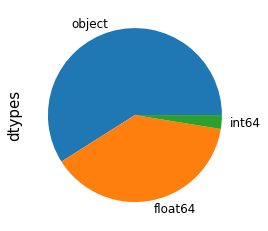

In [9]:
df.dtypes.value_counts().plot.pie(fontsize=12)
plt.ylabel("dtypes", fontsize=15)
plt.savefig(path + "01_dtypesBefore.png", bbox_inches="tight", facecolor="w")

In [10]:
# Converting dates to datetime.
for col in df.loc[
    :,
    [
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
    ],
].columns:
    df.loc[:, col] = df_orders.loc[:, col].apply(
        lambda x: pd.to_datetime(x, format="%Y-%m-%d")
    )

Les données dates sont désormais de type : ```datetime```.

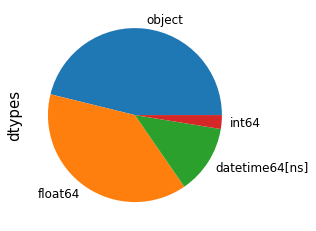

In [11]:
df.dtypes.value_counts().plot.pie(fontsize=12)
plt.ylabel("dtypes", fontsize=15)
plt.savefig(path + "02_dtypesAfter.png", bbox_inches="tight", facecolor="w")

# Traduction des catégories des produits
Dans cette partie, nous rajouterons une colonne pour traduire ```Product_category_name``` en anglais. Nous insérerons une nouvelle colonne sur sa droite avec les traductions correspondantes.
Ci-dessous, il y a deux versions de la même fonction. Au cours de l'exploration, nous nous sommes apperçus qu'il y a des catégories de produits sans traduction anglaise. La fonction a dû être modifier pour prendre en compte ces catégories. Néanmoins, pour la compréhension de la démarche, les étapes menant à ces observations ont été préservées dans ce notebook.

In [12]:
# First version of the translation function that does not include all the categories.
def Translate_to_English_v1(word_to_translate):
    """
    This function translate the input word from portuguese to english.
    [Arguments] :
        - word_to_translate : the portuguese word to be translated to english.
    """
    if (
        word_to_translate
        in df_product_category_name_translation.loc[:, "product_category_name"].tolist()
    ):
        wordRow = df_product_category_name_translation.product_category_name.tolist().index(
            word_to_translate
        )
        return df_product_category_name_translation.loc[
            wordRow, "product_category_name_english"
        ]


# Second version of the translation that include all the categories.
def Translate_to_English(word_to_translate):
    """
    This function translate the input word from portuguese to english.
    [Arguments] :
        - word_to_translate : the portuguese word to be translated to english.
    """
    if (
        word_to_translate
        in df_product_category_name_translation.loc[:, "product_category_name"].tolist()
    ):
        wordRow = df_product_category_name_translation.product_category_name.tolist().index(
            word_to_translate
        )
        return df_product_category_name_translation.loc[
            wordRow, "product_category_name_english"
        ]

    # There are two product categories that are not in "df_product_category_name_translation".
    # We add conditions to translate them below.
    elif word_to_translate == "pc_gamer":
        return "pc_gamer"
    elif word_to_translate == "portateis_cozinha_e_preparadores_de_alimentos":
        return "portable_kitchen_and_food_preparation"

In [13]:
# Creating column for english translation.
if "product_category_name_english" in df.columns:
    df = df.drop(columns=["product_category_name_english"])

df.insert(
    df.columns.get_loc("product_category_name") + 1,
    "product_category_name_english",
    pd.NaT,
)

# Translating to english.
df["product_category_name_english"] = df.loc[:, "product_category_name"].apply(
    Translate_to_English_v1
)

Vérifions si tout les mots sont bien traduits. Pour ce faire, nous supprimons toutes les valeurs manquantes de ```product_category_name``` pour ensuite visualiser les mots sans traduction de ```product_category_name_english```.

In [14]:
# Checking for words that have not been translated.
df.loc[
    ~df.product_category_name.isna() & df.product_category_name_english.isna(),
    ["product_category_name", "product_category_name_english"],
]

,product_category_name,product_category_name_english
32425,pc_gamer,None
32426,pc_gamer,None
32427,pc_gamer,None
32428,pc_gamer,None
32429,pc_gamer,None
32430,pc_gamer,None
48261,portateis_cozinha_e_preparadores_de_alimentos,None
48262,portateis_cozinha_e_preparadores_de_alimentos,None
48263,portateis_cozinha_e_preparadores_de_alimentos,None
51726,portateis_cozinha_e_preparadores_de_alimentos,None


Nous voyons que deux catégories ne sont pas traduites. La première est **pc_gamer**, qui est déjà en anglais. Le second est **portateis_cozinha_e_preparadores_de_alimentos**, qui donne en anglais: **portable_kitchen_and_food_preparation**.

Nous modifions donc notre fonction ```Translate_to_English``` pour inclure ces mots. Pour la traduction, il a été nécessaire de faire appel une personne dont la langue maternelle est le portuguais brézilien, car il était difficile de trouver une bonne traduction en ligne.

In [15]:
# Create column for english translation.
if "product_category_name_english" in df.columns:
    df = df.drop(columns=["product_category_name_english"])

df.insert(
    df.columns.get_loc("product_category_name") + 1,
    "product_category_name_english",
    pd.NaT,
)

# Translate to english.
df["product_category_name_english"] = df.loc[:, "product_category_name"].apply(
    Translate_to_English
)

In [16]:
# Checking for words that have not been translated.
df.loc[
    ~df.product_category_name.isna() & df.product_category_name_english.isna(),
    ["product_category_name", "product_category_name_english"],
]

,product_category_name,product_category_name_english


Le tableau ci-dessus est vide, indiquant que tout les mots de ```product_category_name``` ont été traduits en anglais.

In [17]:
# Exporting the dataset for part 3 : study of stability of clusters.
df.to_csv("dataset_part3.csv")

In [18]:
df.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_item_id                           float64
product_id                               object
seller_id                                object
shipping_limit_date                      object
price                                   float64
freight_value                           float64
product_category_name                    object
product_category_name_english            object
product_name_lenght                     

# Les catégories les plus achetées par ordre décroissant
Visualisons à l'aide d'un graphique la proportion des catégories commandées par les clients.

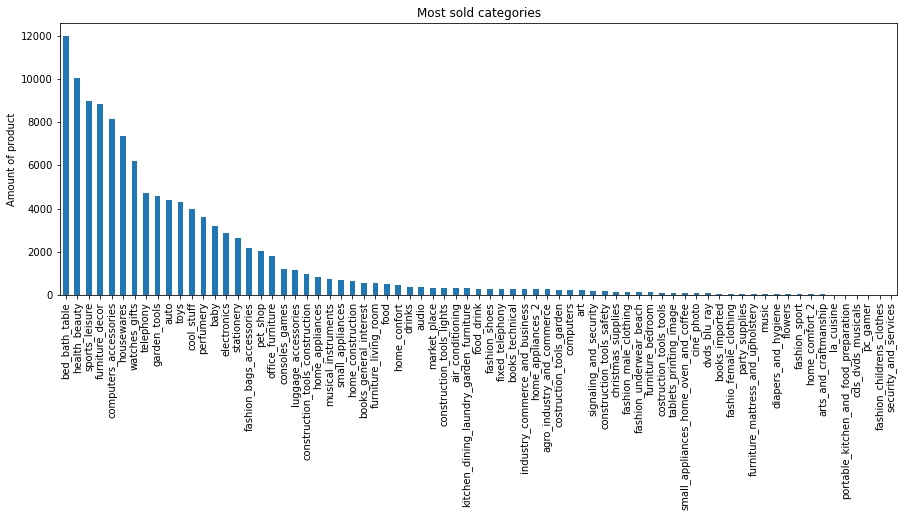

In [19]:
# Product categories
plt.figure(figsize=(15, 5))
plt.title("Most sold categories")
df.product_category_name_english.value_counts().plot.bar()
plt.ylabel("Amount of product")
plt.xticks(rotation="90")
plt.savefig(path + "03_MostSoldCategories.png", bbox_inches="tight", facecolor="w")

La catégorie qui est le plus vendue est : **bed_bath_table**.
Regardons maintenant quelle catégorie rapporte plus d'argent.

# L'argent rapporté par catégorie


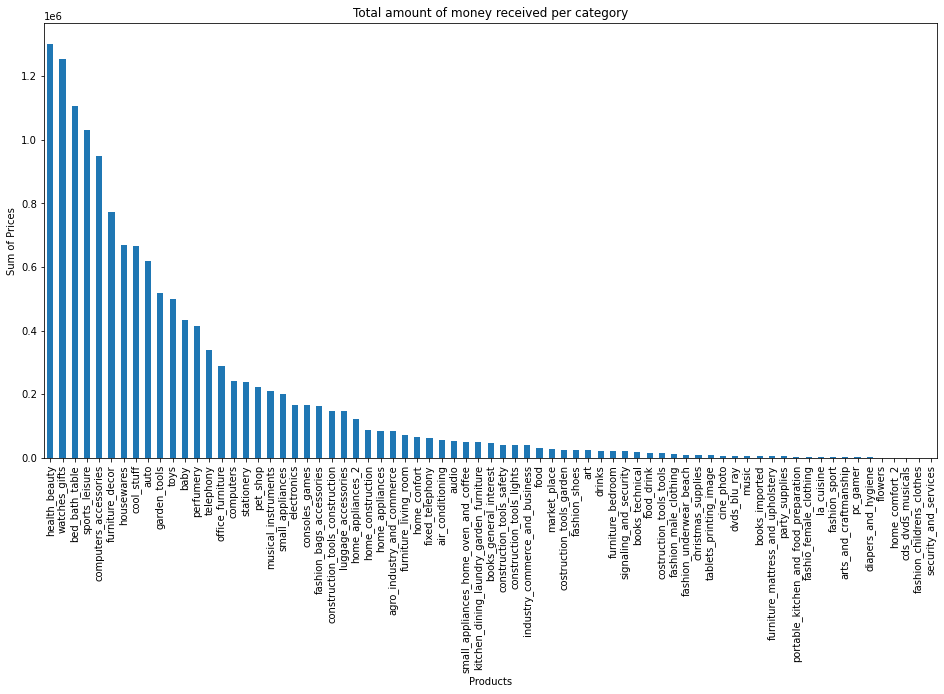

In [20]:
plt.figure(figsize=(16, 8))
df.groupby(["product_category_name_english"])["price"].sum().sort_values(
    ascending=False
).plot.bar()
plt.title("Total amount of money received per category")
plt.xlabel("Products")
plt.ylabel("Sum of Prices")
plt.savefig(
    path + "04_CategoriesBringMoreMoney.png", bbox_inches="tight", facecolor="w"
)

Les produits qui rapportent le plus d'argent sont les produits de beauté et de santé.

# <font size='7'>2) Analyse RFM</font>

# Frequency
Nous identifierons ici le nombre de fois qu'un clients à acheter un article. Cela nous permettra de supprimer les clients ayant acheté qu'une fois et de nous intéresser

In [21]:
# Customers that bought more than once.
# List of these customers
list_of_customers = pd.DataFrame(
    df.loc[:, "customer_unique_id"].value_counts()
).reset_index()
list_of_customers.rename(
    columns={"index": "customer_unique_id", "customer_unique_id": "Frequency"},
    inplace=True,
)
print(f"Dimension of list_of_customers : {list_of_customers.shape}")
list_of_customers.head()

Dimension of list_of_customers : (96096, 2)


,customer_unique_id,Frequency
0,9a736b248f67d166d2fbb006bcb877c3,75
1,6fbc7cdadbb522125f4b27ae9dee4060,38
2,f9ae226291893fda10af7965268fb7f6,35
3,8af7ac63b2efbcbd88e5b11505e8098a,29
4,569aa12b73b5f7edeaa6f2a01603e381,26


In [22]:
# Customers who bought more than once.
Frequency = list_of_customers.loc[list_of_customers.Frequency > 1, :]
print(f"Dimension of customers_more_one_order : {Frequency.shape}")

Dimension of customers_more_one_order : (14495, 2)


In [23]:
# Percentage of customers who bought more than one article.
percentageCustomers = len(Frequency) / len(list_of_customers)
print(
    f"Percentage of customers who bought more than one item : {percentageCustomers*100:.2f}%"
)

Percentage of customers who bought more than one item : 15.08%


# Monetary
Nous voulons connaître ici la somme totale dépensées par chaque client.

In [24]:
# Money spent per customers.
customers_expenses = pd.DataFrame(
    df.groupby(["customer_unique_id"])["price"].sum()
).reset_index()
print(f"Dimension of customers_expenses : {customers_expenses.shape}")
customers_expenses.head()

Dimension of customers_expenses : (96096, 2)


,customer_unique_id,price
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00


In [25]:
# Getting expenses together with frequency.
expenses_frequency = (
    pd.merge(Frequency, customers_expenses, on="customer_unique_id", how="left")
    .sort_values(by="customer_unique_id", ascending=False)
    .reset_index(drop=True)
)
print(f"Dimension of expenses_frequency : {expenses_frequency.shape}")
expenses_frequency.head()

Dimension of expenses_frequency : (14495, 3)


,customer_unique_id,Frequency,price
0,fffcf5a5ff07b0908bd4e2dbc735a684,2,1570.0
1,fff7219c86179ca6441b8f37823ba3d3,2,245.8
2,fff5eb4918b2bf4b2da476788d42051c,6,1050.0
3,fff22793223fe80c97a8fd02ac5c6295,3,66.0
4,ffeddf8aa7cdecf403e77b2e9a99e2ea,2,330.0


# Recency
Nous allons maintenant chercher à calculer la récence. Regardons la distribution des fréquences d'achat de nos clients dans un premier temps.


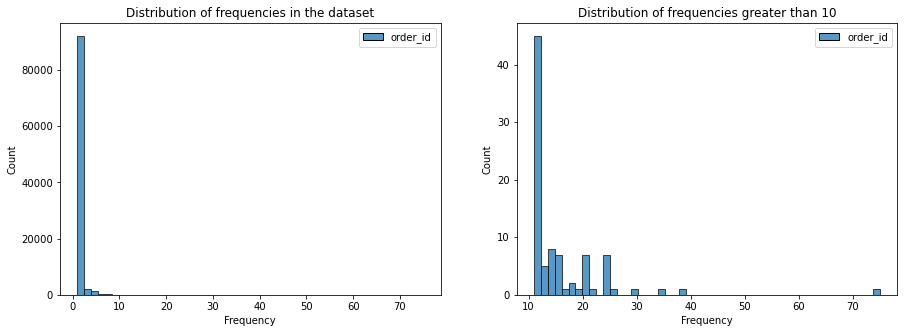

In [26]:
number_of_order = pd.DataFrame(
    df.groupby("customer_unique_id")["order_id"].count()
).reset_index()
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot(number_of_order, bins=50)
plt.title("Distribution of frequencies in the dataset")
plt.xlabel("Frequency")

plt.subplot(1, 2, 2)
plt.title("Distribution of frequencies greater than 10")
sns.histplot(number_of_order.loc[number_of_order.loc[:, "order_id"] > 10, :], bins=50)
plt.xlabel("Frequency")
plt.savefig(path + "05_Frequency_distribution.png", bbox_inches="tight", facecolor="w")

Ci-dessus à gauche, nous avons la distribution complète de la fréquence. À droite, nous avons la distribution pour les fréquences supérieures à 10. Un zoom est nécessaire, car il y a beaucoup plus de clients ponctuelles que de clients réguliers. La majorité des clients présents dans nos datasets a acheté une fois. Cependant, plusieurs clients, une minorité, ont acheté des articles plus de 10 fois, et le records est de 75 commandes.

## Calcul de la Récence
Nous calculerons désormais la récence. Ici, ce sera le temps écoulé entre les deux derniers achats de chaque clients. Le code ci-dessous effectue ce calcul et ces informations sont ensuite combinées avec les informations sur la fréquence et les dépenses.

In [27]:
# Function to calculate recency for each customer.
def Customer_Recency(customer):
    """
    This function takes as argument the customer, and calculate the number of days between the two last purchases of that customer.
    [Argument] :
        - customer : the customer for whom we want to calculate the recency in days.
    """

    customer_data = (
        df.loc[df.loc[:, "customer_unique_id"] == customer, :]
        .sort_values(by="order_purchase_timestamp", ascending=False)
        .reset_index()
    )
    if len(customer_data) > 1:
        return (
            customer_data.loc[0, "order_purchase_timestamp"]
            - customer_data.loc[1, "order_purchase_timestamp"]
        )

In [28]:
# Calculating Recency for each customer in ``èxpenses_frequency``` dataframe.
expenses_frequency["Recency"] = expenses_frequency.loc[:, "customer_unique_id"].apply(
    Customer_Recency
)

Ce dataset contient des valeurs manquantes puisque les dates d'achats de certains clients sont manquantes. Nous supprimerons donc ces lignes et étudierons les clients pour lesquelles nous avons les informations nécessaires pour l'analyse RFM.

In [29]:
# A new dataframe is created to store the Recency, Frequency and Monetary information.
rfm = (
    expenses_frequency.copy()
    .sort_values(by="Recency", ascending=True)
    .dropna()
    .reset_index(drop=True)
)
rfm.loc[:, "Recency"] = rfm.Recency.dt.days
rfm.rename(columns={"price": "Monetary"}, inplace=True)
rfm

,customer_unique_id,Frequency,Monetary,Recency
0,1b6c7548a2a1f9037c1fd3ddfed95f33,10,855.21,0
1,1fa9b1d14629ef237e0b2f570030df90,2,149.80,0
2,de083d6adb27920ff993b75eac74be01,6,45.78,0
3,a298cb329fd2b41fbb02a0e66a7c27ef,2,599.80,0
4,1985ee4e25eee7fc657c6052e733c3d3,2,249.98,0
...,...,...,...,...
12006,41140f3b59638c033faaef72b6d4ae2d,2,124.00,615
12007,5f435bbe57e905e19378fa56b60e9d16,2,119.70,644
12008,8bbf6202da669bd5559f49f84af1d218,2,77.80,672
12009,c2f6235aa74caf5b3b21c12a429a0dcf,2,59.98,677


In [30]:
print(f"Total number of missing values in rfm :{rfm.isna().sum()}")
expenses_frequency

Total number of missing values in rfm :customer_unique_id    0
Frequency             0
Monetary              0
Recency               0
dtype: int64


,customer_unique_id,Frequency,price,Recency
0,fffcf5a5ff07b0908bd4e2dbc735a684,2,1570.0,NaT
1,fff7219c86179ca6441b8f37823ba3d3,2,245.8,65 days 22:42:25
2,fff5eb4918b2bf4b2da476788d42051c,6,1050.0,NaT
3,fff22793223fe80c97a8fd02ac5c6295,3,66.0,NaT
4,ffeddf8aa7cdecf403e77b2e9a99e2ea,2,330.0,69 days 03:14:44
...,...,...,...,...
14490,000fbf0473c10fc1ab6f8d2d286ce20c,4,285.8,50 days 04:10:14
14491,000e309254ab1fc5ba99dd469d36bdb4,2,119.8,302 days 06:56:54
14492,000de6019bb59f34c099a907c151d855,2,229.8,188 days 04:52:10
14493,000bfa1d2f1a41876493be685390d6d3,2,70.0,NaT


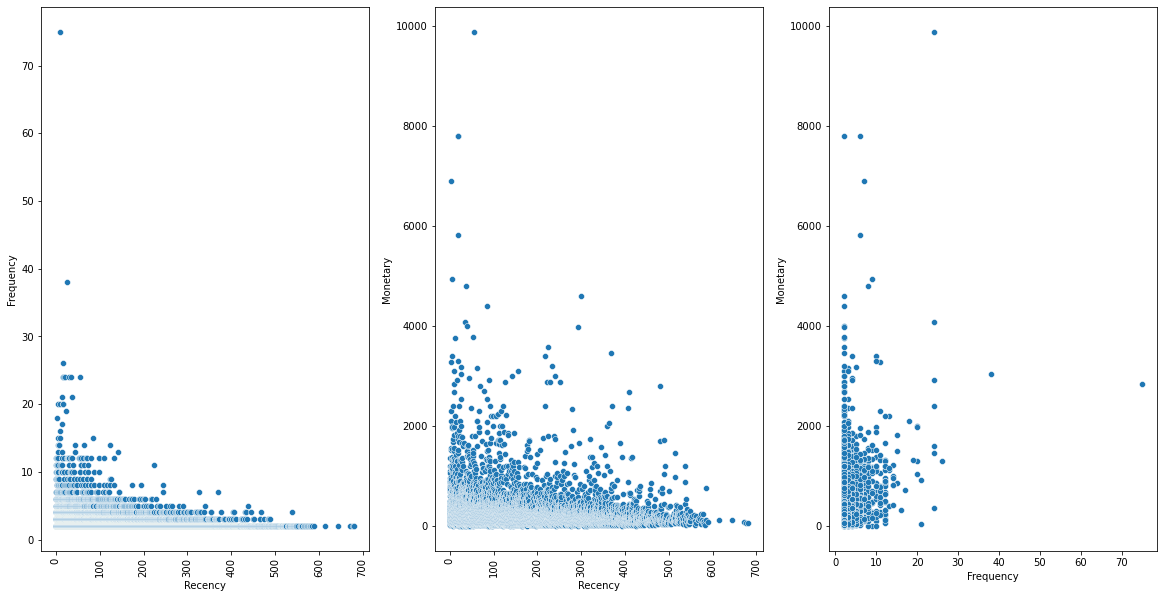

In [31]:
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm, x="Recency", y="Frequency")
plt.xticks(rotation="90")
plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm, x="Recency", y="Monetary")
plt.xticks(rotation="90")
plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm, x="Frequency", y="Monetary")
plt.savefig(path + "06_RFM_2Dplots.png", bbox_inches="tight", facecolor="w")

plt.show()

Ces trois graphiques ne nous permet pas d'identifier des clusters pour segmenter les clients. Ce que nous allons faire c'est d'établir un score en fonction de la récence, la fréquence et des dépenses. Ensuite, en utilisant l'algorithme ```TSNE```, nous chercherons à identifier des groupes de clients ayant des points communs.

# RFM Scoring
Nous voulons ici établir un score pour chaque client en fonction de sa récence, sa fréquence et de ses dépenses. Nous créons donc les fonctions nécessaires pour ce scoring.

In [32]:
# Function to attribute the score to each customer.
def Recency(x):
    """This function gives a score according to the recency of the input date.
    [Argument]:
        - x : input date.
    """
    if x >= 0.8 * rfm.Recency.max():
        return 1
    elif x >= 0.6 * rfm.Recency.max() and x < 0.8 * rfm.Recency.max():
        return 2
    elif x >= 0.4 * rfm.Recency.max() and x < 0.6 * rfm.Recency.max():
        return 3
    elif x >= 0.2 * rfm.Recency.max() and x < 0.4 * rfm.Recency.max():
        return 4
    elif x < 0.2 * rfm.Recency.max():
        return 5


# Function to attribute Frequency score to each customer
def Frequency(x):
    """This function gives a score according to the frequency of each customer.
    [Argument]:
        - x : input frequency.
    """
    if x >= 0.8 * rfm.Frequency.max():
        return 5
    elif x >= 0.6 * rfm.Frequency.max() and x < 0.8 * rfm.Frequency.max():
        return 4
    elif x >= 0.4 * rfm.Frequency.max() and x < 0.6 * rfm.Frequency.max():
        return 3
    elif x >= 0.2 * rfm.Frequency.max() and x < 0.4 * rfm.Frequency.max():
        return 2
    elif x < 0.2 * rfm.Frequency.max():
        return 1


# Function to attribute Monetary score to each customer
def Monetary(x):
    """This function gives a score according to the expenses of each customer.
    [Argument]:
        - x : input total expense.
    """
    if x >= 0.9 * rfm.Monetary.max():
        return 10
    elif x >= 0.8 * rfm.Monetary.max() and x < 0.9 * rfm.Monetary.max():
        return 9
    elif x >= 0.7 * rfm.Monetary.max() and x < 0.8 * rfm.Monetary.max():
        return 8
    elif x >= 0.6 * rfm.Monetary.max() and x < 0.7 * rfm.Monetary.max():
        return 7
    if x >= 0.5 * rfm.Monetary.max() and x < 0.6 * rfm.Monetary.max():
        return 6
    elif x >= 0.4 * rfm.Monetary.max() and x < 0.5 * rfm.Monetary.max():
        return 5
    elif x >= 0.3 * rfm.Monetary.max() and x < 0.4 * rfm.Monetary.max():
        return 4
    elif x >= 0.2 * rfm.Monetary.max() and x < 0.3 * rfm.Monetary.max():
        return 3
    elif x >= 0.1 * rfm.Monetary.max() and x < 0.2 * rfm.Monetary.max():
        return 2
    elif x < 0.1 * rfm.Monetary.max():
        return 1


# Function to calculate RFM Score.
def RFM_Score(x, y, z):
    """This function calculates the RFM score.
    [Arguments]:
        - x : Recency score.
        - y : Frequency score.
        - z : Monetary score.
    """
    return 100 * x + 10 * y + z
    # return x**4 + y**1.5 + np.log(z)

In [33]:
# Calculating Recency Score.
rfm["Recency_score"] = rfm.loc[:, "Recency"].apply(Recency)

# Calculating Frequency Score
rfm["Frequency_score"] = rfm.loc[:, "Frequency"].apply(Frequency)

# Calculating Monetary Score
rfm["Monetary_score"] = rfm.loc[:, "Monetary"].apply(Monetary)

In [34]:
# Statistical description of the ```rfm``` dataset.
rfm.describe(datetime_is_numeric=True)

,Frequency,Monetary,Recency,Recency_score,Frequency_score,Monetary_score
count,12011.000000,12011.000000,12011.000000,12011.000000,12011.000000,12011.000000
mean,2.592207,236.946981,152.796520,4.318292,1.002248,1.035384
std,1.635947,342.111242,123.203138,0.872762,0.058385,0.272216
min,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,2.000000,89.800000,52.500000,4.000000,1.000000,1.000000
50%,2.000000,150.000000,123.000000,5.000000,1.000000,1.000000
75%,3.000000,264.245000,224.000000,5.000000,1.000000,1.000000
max,75.000000,9888.000000,681.000000,5.000000,5.000000,10.000000


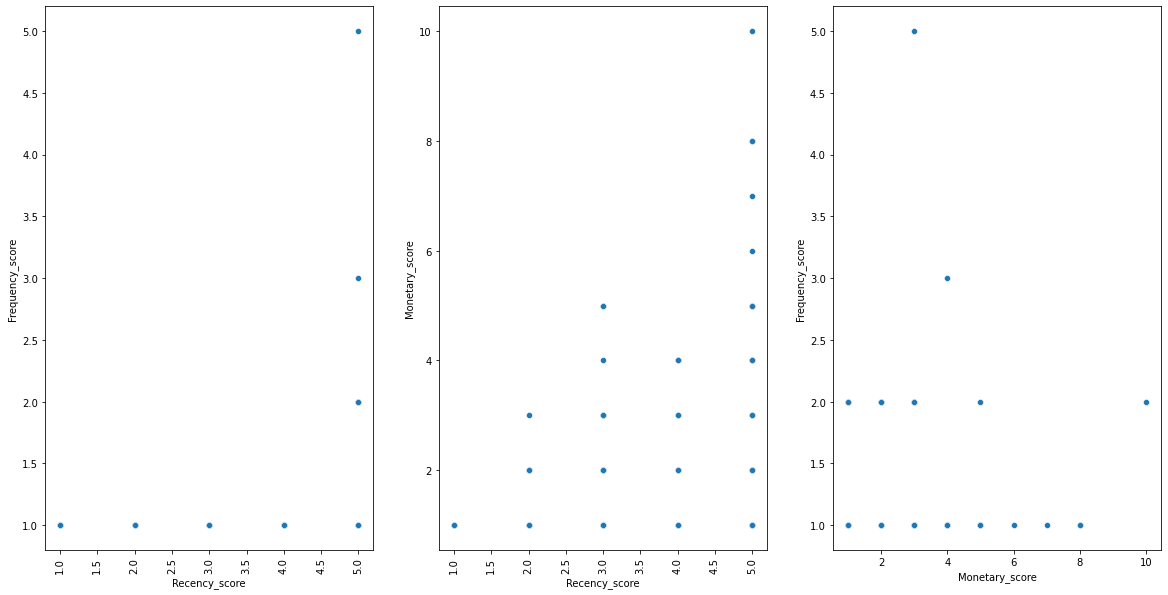

In [35]:
# Plotting the scores.
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm, x="Recency_score", y="Frequency_score")
plt.xticks(rotation="90")
plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm, x="Recency_score", y="Monetary_score")
plt.xticks(rotation="90")
plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm, x="Monetary_score", y="Frequency_score")
plt.show()

In [36]:
# Calculating RFM Score
rfm.loc[:, "RFM_score"] = [
    RFM_Score(
        rfm.loc[i, "Recency_score"],
        rfm.loc[i, "Frequency_score"],
        rfm.loc[i, "Monetary_score"],
    )
    for i in range(rfm.shape[0])
]

# Data is reordered in descending order of RFM Scores.
rfm = rfm.sort_values(by="RFM_score", ascending=False).reset_index(drop=True)

In [37]:
# Statistical description of the ```rfm``` dataset.
rfm.describe(datetime_is_numeric=True)

,Frequency,Monetary,Recency,Recency_score,Frequency_score,Monetary_score,RFM_score
count,12011.000000,12011.000000,12011.000000,12011.000000,12011.000000,12011.000000,12011.00000
mean,2.592207,236.946981,152.796520,4.318292,1.002248,1.035384,442.88702
std,1.635947,342.111242,123.203138,0.872762,0.058385,0.272216,87.30621
min,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,111.00000
25%,2.000000,89.800000,52.500000,4.000000,1.000000,1.000000,411.00000
50%,2.000000,150.000000,123.000000,5.000000,1.000000,1.000000,511.00000
75%,3.000000,264.245000,224.000000,5.000000,1.000000,1.000000,511.00000
max,75.000000,9888.000000,681.000000,5.000000,5.000000,10.000000,553.00000


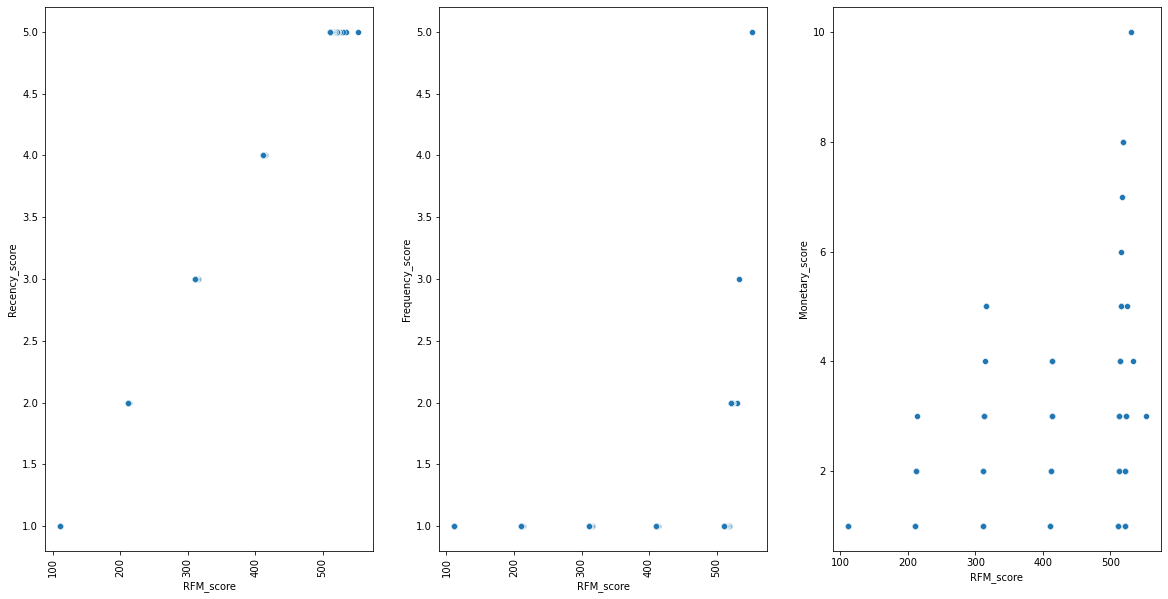

In [38]:
# RFM score against other scores.
fig = plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1)
sns.scatterplot(data=rfm, x="RFM_score", y="Recency_score")
plt.xticks(rotation="90")
plt.subplot(1, 3, 2)
sns.scatterplot(data=rfm, x="RFM_score", y="Frequency_score")
plt.xticks(rotation="90")
plt.subplot(1, 3, 3)
sns.scatterplot(data=rfm, x="RFM_score", y="Monetary_score")
plt.show()

# Enregistrement du dataset : <b>rfm</b>
Le dataset est enregistré pour la recherche de clusters pour la segmentation de clients.

In [39]:
# Saving the rfm table for part 2, where customers will be segmented.
rfm.to_csv("RFM.csv")